In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import sys
sys.path.append('..')

import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import multiprocessing
from functools import partial
from PIL import Image
import numbergen as ng
import imagen as ig
from skimage.transform import resize
import time
import cv2
from ssn.random_pattern import random_pattern
import numbergen as ng
import imagen as ig
import random
import imageio
import metric

def show(img, title='',cmap=None): 
    plt.figure(figsize=(15,10))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()
    
def normalize(ibl, energy=3500):
    total_energy = np.sum(ibl)
    if total_energy < 1e-3:
        print('small energy: ', total_energy)
        return np.zeros((80,512))

    ibl = ibl * energy / total_energy

    return ibl

def to_normalized_ibl(ibl):
    """ input is pattern generated ibl [80x512]
        output is noramlized ibl: [16x32]
    """
    ibl = cv2.resize(ibl, (32, 5))
    ret = np.zeros((16, 32))
    ret[:5,:] = ibl
    return ret

def get_files(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def get_folders(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

## Prepare a dictionary 

ibl_key -> [[mts, pred, net_gt],[mts, pred, net_gt],[mts, pred, net_gt], ....]

In [30]:
result_folder = '/home/ysheng/Dataset/evaluation/'

model_list = get_folders(result_folder)
dbg, dbg_num = True, 1

"""
    ibl key -> files
"""
ibl_dict = {}

ibl_folder = join(model, 'pattern')
ibl_folders = get_folders(ibl_folder)

for ibl_f in ibl_folders:
    ibl_name = os.path.basename(ibl_f)
    ibl_dict[ibl_name] = []

ibl_keys = ibl_dict.keys()
print('ibl files: {}'.format(len(ibl_keys)))

# for ibl in tqdm(ibl_dict.keys()):
#     for model in model_list:
#         cur_folder = join(model, join('pattern', ibl))
#         gt_path, pred_path, mitsuba_path = join(cur_folder, 'gt.png'), join(cur_folder, 'predict.png'), join(cur_folder, 'mitsuba_shadow.exr')

#         ibl_dict[ibl].append([gt_path, pred_path, mitsuba_path])

ibl files: 260


ibl_num -> [[mts, pred, net_gt]]


ibl_size -> [[mts, pred, net_gt]]

In [75]:
ibl_num_dict, ibl_size_dict = dict(), dict()
def parse_key(key):
    """ key -> num, size
    """
    num = key[key.find('num_') + len('num_'):key.find('_size_')]
    size = key[key.find('size_') + len('size_'):key.find('_ibl')]
    return int(num), float(size)

for ibl in tqdm(ibl_keys):
    num, size = parse_key(ibl)
    
    if num not in ibl_num_dict.keys():
        ibl_num_dict[num] = []
        
    if size not in ibl_size_dict.keys():
        ibl_size_dict[size] = []
    
    ibl_num_dict[num].append(ibl)
    ibl_size_dict[size].append(ibl)

    
print('#: {}, size: {}, model: {}'.format(len(ibl_num_dict.keys()), len(ibl_size_dict.keys()),len(model_list)))







100%|██████████| 260/260 [00:00<00:00, 297549.53it/s]A

#: 26, size: 10, model: 10


## compute ibl num metrices

In [76]:
def np_property(img):
    print('shape: {}, min: {}, max: {}'.format(img.shape, np.min(img), np.max(img)))

def compute_metric(gt_np, pred_np, mts_np):
    gt_mts = [metric.rmse(gt_np, mts_np), metric.rmse_s(gt_np, mts_np)[1], metric.ZNCC(gt_np, mts_np)]
    pred_mts = [metric.rmse(pred_np, mts_np), metric.rmse_s(pred_np, mts_np)[1], metric.ZNCC(pred_np, mts_np)]
    return np.array(gt_mts), np.array(pred_mts)

In [114]:
# ori_num_metric = np.copy(num_metric)
# ori_size_metric = np.copy(size_metric)
print(ori_num_metric)
print(metric_dict)

{15: array([[0.01350358, 0.01267972, 0.94932609],
       [0.02793415, 0.02711215, 0.76912462]]), 49: array([[0.01542377, 0.01442066, 0.93555277],
       [0.02980063, 0.02899135, 0.73253095]]), 43: array([[0.01693606, 0.0155866 , 0.93467854],
       [0.03143057, 0.0308123 , 0.73154994]]), 13: array([[0.01717344, 0.01557307, 0.94946169],
       [0.03778279, 0.03514702, 0.74563378]]), 5: array([[0.01724708, 0.01469435, 0.9693047 ],
       [0.04402064, 0.03973706, 0.75133928]]), 27: array([[0.01831116, 0.01687626, 0.93312817],
       [0.03529563, 0.03433643, 0.70698698]]), 23: array([[0.01762454, 0.01581675, 0.93789793],
       [0.03488972, 0.03386556, 0.71925725]]), 41: array([[0.0169906 , 0.01563286, 0.92401213],
       [0.03077741, 0.03034357, 0.70733325]]), 19: array([[0.02253029, 0.02087958, 0.91146413],
       [0.04092811, 0.03962089, 0.66097567]]), 31: array([[0.01587563, 0.01480843, 0.93782836],
       [0.0308893 , 0.03010875, 0.73650734]]), 9: array([[0.01841198, 0.01682731, 0.944

In [117]:
num_metric = {}
# for num in tqdm(ibl_num_dict.keys()):
#     num_metric[num] = np.zeros((2,3))
#     sample_num = len(model_list) * len(ibl_num_dict[num])
    
#     print('{} ibl has {} samples'.format(num, sample_num))
#     for ibl_folder in ibl_num_dict[num]: 
#         for m in model_list:
#             cur_folder = join(m, join('pattern', ibl_folder))
            
#             gt_path, pred_path, mitsuba_path = join(cur_folder, 'gt.png'), join(cur_folder, 'predict.png'), join(cur_folder, 'mitsuba_shadow.exr')
#             gt_np, pred_np, mts_np = plt.imread(gt_path)[:,:,0], plt.imread(pred_path)[:,:,0], 1.0 - imageio.imread(mitsuba_path)[:,:,0]
            
#             # gt_np -> mts_np(mse, mses, zncc)
#             # pred_np -> mts_np(mse, mses, zncc)
#             # average over all samples
#             gt_mts, pred_mts = compute_metric(gt_np, pred_np, mts_np)
#             num_metric[num][0] += gt_mts / sample_num
#             num_metric[num][1] += pred_mts / sample_num
            
# #             np_property(gt_np)
# #             np_property(pred_np)
# #             np_property(mts_np)  
# #             show(gt_np)
# #             show(pred_np)
# #             show(mts_np)

# parallel version
def worker(input_param):
    ibl_key, ibl_dict = input_param
    sample_num = len(ibl_dict[ibl_key]) * len(model_list)
    cur_metric = np.zeros((2,3))
    for ibl_folder in ibl_dict[ibl_key]: 
        for m in model_list:
            cur_folder = join(m, join('pattern', ibl_folder))
            
            gt_path, pred_path, mitsuba_path = join(cur_folder, 'gt.png'), join(cur_folder, 'predict.png'), join(cur_folder, 'mitsuba_shadow.exr')
            gt_np, pred_np, mts_np = plt.imread(gt_path)[:,:,0], plt.imread(pred_path)[:,:,0], 1.0 - imageio.imread(mitsuba_path)[:,:,0]
            
            # gt_np -> mts_np(mse, mses, zncc)
            # pred_np -> mts_np(mse, mses, zncc)
            # average over all samples
            gt_mts, pred_mts = compute_metric(gt_np, pred_np, mts_np)
            cur_metric[0] += gt_mts / sample_num
            cur_metric[1] += pred_mts / sample_num
    return (ibl_key, cur_metric)

#
#
def parallel_metric(metric_dict, processor_num = 32):
    s = time.time()
    
    # (net_gt, pred) x (mse, mse_s, zncc)
#     metric_result = np.zeros((len(metric_dict.keys()), 2, 3))
    metric_result = {}
    for k in metric_dict.keys():
        metric_result[k] = np.zeros((2,3))
    
    task_num = len(metric_dict.keys())
    input_list = zip(metric_dict.keys(), [metric_dict] * len(metric_dict.keys()))
    
    with multiprocessing.Pool(processor_num) as pool:
        # working_fn = partial(batch_working_process, src_folder, out_folder)
        for i, cur_result in enumerate(pool.imap_unordered(worker, input_list), 1):
            ibl_key, cur_metric = cur_result
            metric_result[ibl_key] = cur_metric
            
            print("Finished: {} \r".format(float(i)/task_num), flush=True, end='')
    print('time: {} s'.format(time.time() - s))
    return metric_result

num_metric = parallel_metric(ibl_num_dict)
size_metric = parallel_metric(ibl_size_dict)

time: 3.223684072494507 s616   
time: 3.078256607055664 s


In [120]:
size_metric = {}
for size in tqdm(ibl_size_dict.keys()):
    size_metric[size] = np.zeros((2,3))
    sample_num = len(model_list) * len(ibl_size_dict[size])
    
#     print('{} ibl has {} samples'.format(size, sample_num))
    for ibl_folder in ibl_size_dict[size]: 
        for m in model_list:
            cur_folder = join(m, join('pattern', ibl_folder))
            
            gt_path, pred_path, mitsuba_path = join(cur_folder, 'gt.png'), join(cur_folder, 'predict.png'), join(cur_folder, 'mitsuba_shadow.exr')
            gt_np, pred_np, mts_np = plt.imread(gt_path)[:,:,0], plt.imread(pred_path)[:,:,0], 1.0 - imageio.imread(mitsuba_path)[:,:,0]
            
            # gt_np -> mts_np(mse, mses, zncc)
            # pred_np -> mts_np(mse, mses, zncc)
            # average over all samples
            gt_mts, pred_mts = compute_metric(gt_np, pred_np, mts_np)
            size_metric[size][0] += gt_mts / sample_num
            size_metric[size][1] += pred_mts / sample_num

#             np_property(gt_np)
#             np_property(pred_np)
#             np_property(mts_np)  
#             show(gt_np)
#             show(pred_np)
#             show(mts_np)







  0%|          | 0/10 [00:00<?, ?it/s]





 10%|█         | 1/10 [00:29<04:21, 29.05s/it]





 20%|██        | 2/10 [01:00<03:59, 29.88s/it]





 30%|███       | 3/10 [01:10<02:46, 23.76s/it]





 40%|████      | 4/10 [01:12<01:44, 17.33s/it]





 50%|█████     | 5/10 [01:15<01:04, 12.98s/it]





 60%|██████    | 6/10 [01:22<00:44, 11.21s/it]





 70%|███████   | 7/10 [01:26<00:26,  8.89s/it]





 80%|████████  | 8/10 [01:28<00:13,  6.90s/it]





 90%|█████████ | 9/10 [01:30<00:05,  5.50s/it]





100%|██████████| 10/10 [01:56<00:00, 11.67s/it]


In [121]:
ori_size_metric = size_metric

In [ ]:
# print(np.sum(num_metric - ori_num_metric))
# print(np.sum(size_metric- ori_size_metric))

for k in size_metric.keys():
    print('diff: ',np.sum(size_metric[k]-ori_size_metric[k]))

## Result Plot

In [88]:
print('num metric: {}, size metric: {}'.format(len(num_metric.keys()), len(size_metric.keys())))

num_keys, size_keys = list(num_metric.keys()), list(size_metric.keys())
    
num_keys.sort()
size_keys.sort()
print(num_keys)
print(size_keys)

num_gt_mts, num_pred_mts = [], []
size_gt_mts,size_pred_mts = [], []

for num in num_keys:
    num_gt_mts.append(num_metric[num][0])
    num_pred_mts.append(num_metric[num][1])
    
for size in size_keys:
    size_gt_mts.append(size_metric[size][0])
    size_pred_mts.append(size_metric[size][1])

num_gt_mts = np.array(num_gt_mts)
num_pred_mts = np.array(num_pred_mts)
size_gt_mts = np.array(size_gt_mts)
size_pred_mts = np.array(size_pred_mts)

print(num_gt_mts.shape)
print(num_pred_mts.shape)
print(size_gt_mts.shape)
print(size_pred_mts.shape)

num metric: 26, size metric: 10
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51]
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
(26, 3)
(26, 3)
(10, 3)
(10, 3)


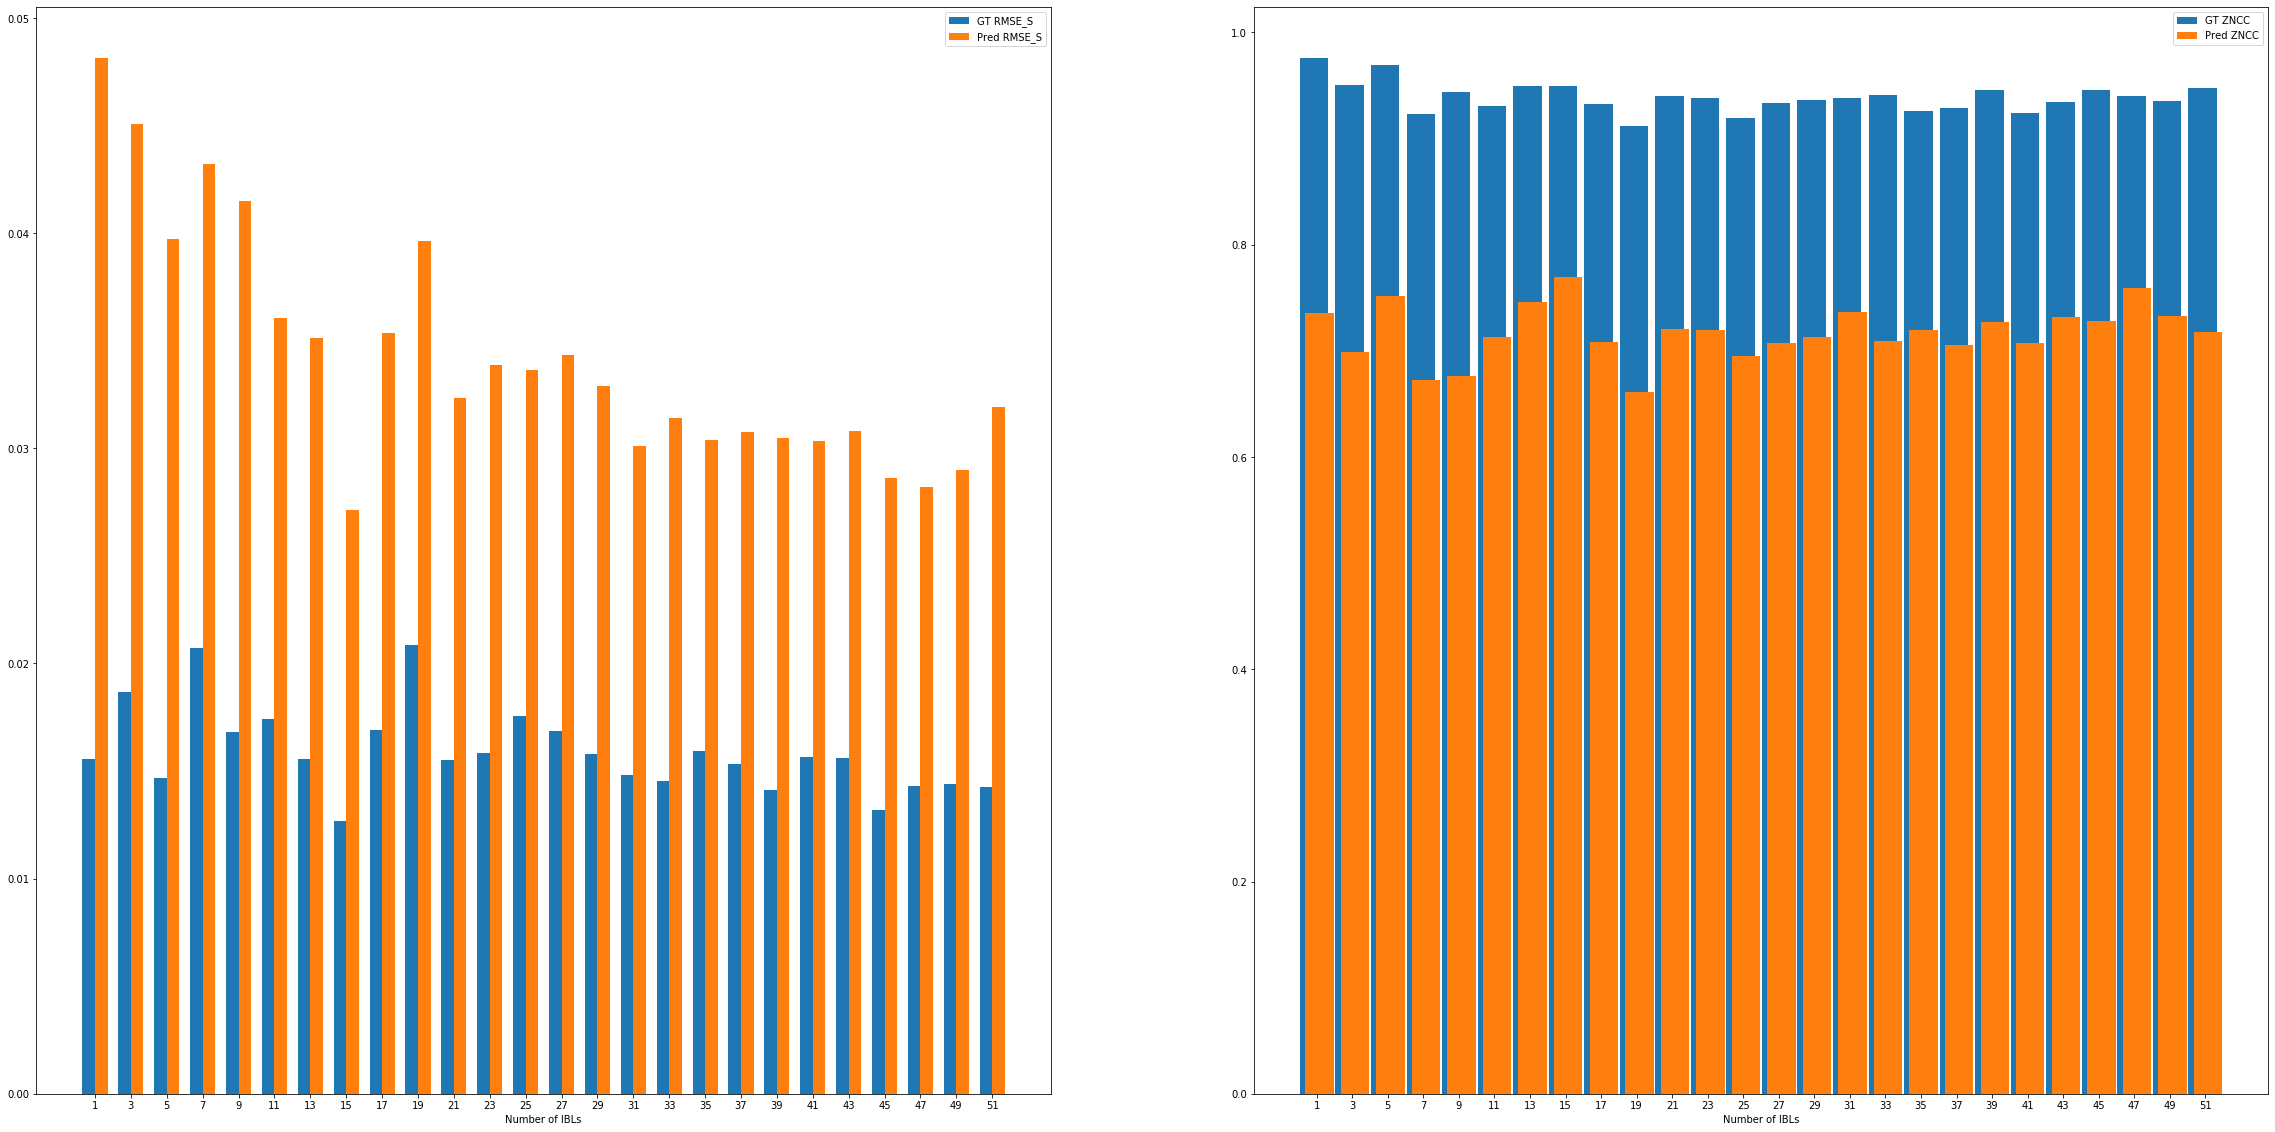

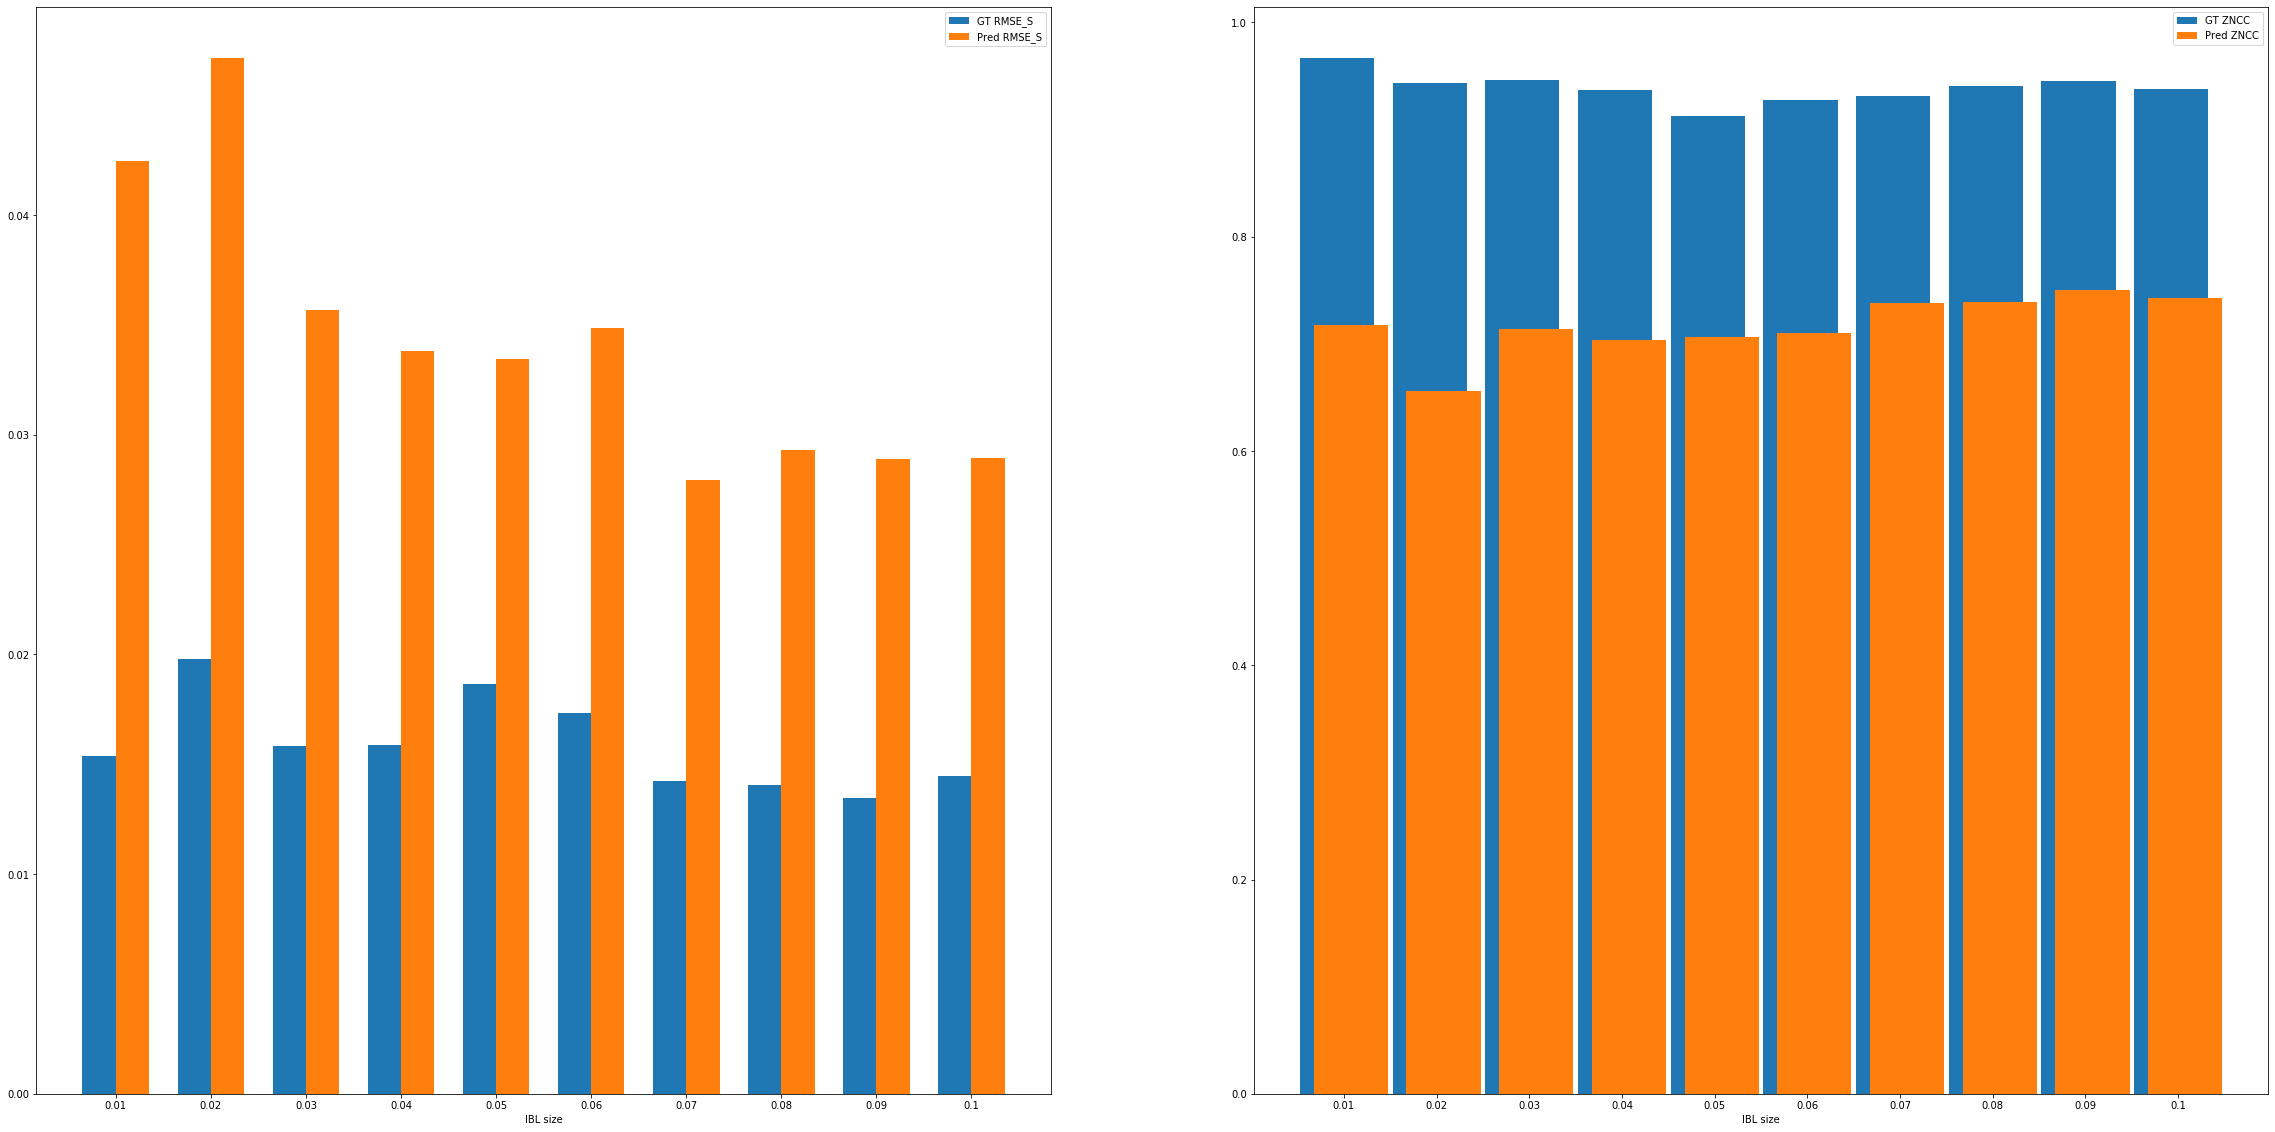

In [103]:
def plot_metric(x_values, gt_mts, pred_mts, x_label,save_path=''):
    plt.figure(figsize=(40, 20))
    plt.title('GT vs Mitsuba')
    width = 0.35
    
    plt.subplot(1,2,1)
    ind = np.arange(gt_mts.shape[0]) 
#     plt.bar(ind + width * 0, gt_mts[:, 0], width, label='GT RMSE')
#     plt.bar(ind + width * 1, pred_mts[:, 0], width, label='Pred RMSE')
    plt.bar(ind + width * 0, gt_mts[:, 1], width, label='GT RMSE_S')
    plt.bar(ind + width * 1, pred_mts[:, 1], width, label='Pred RMSE_S')
    plt.xlabel(x_label)
    plt.xticks(ind + width/2, x_values)
    plt.legend(loc='best')

    
    plt.subplot(1,2,2)
    plt.bar(ind+ width * 0, gt_mts[:, 2], label='GT ZNCC')
    plt.bar(ind + width * 1, pred_mts[:, 2], label='Pred ZNCC')
    plt.xlabel(x_label)
    plt.xticks(ind + width / 2, x_values)
    plt.legend(loc='best')

    plt.show()
    if save_path != '':
        plt.savefig(save_path)
    
    
plot_metric(num_keys, num_gt_mts, num_pred_mts, 'Number of IBLs', "num_metric.png")
# plot_metric(num_keys, num_pred_mts, 'Number of IBLs')
plot_metric(size_keys, size_gt_mts, size_pred_mts, 'IBL size', "size_metric.png")
# plot_metric(size_keys, size_pred_mts, 'IBL size')

In [ ]:
width = 0.35       
plt.bar(ind, men_means, width, label='Men')
plt.bar(ind + width, women_means, width, label='Women')